In [1]:
#| default_exp core

In [2]:
#| export
import concurrent
import io
import logging
import re
import re2

import cairosvg
import kagglehub
import torch
from lxml import etree
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers.models.gemma3 import Gemma3ForConditionalGeneration, Gemma3Processor, Gemma3ForCausalLM

svg_constraints = kagglehub.package_import('metric/svg-constraints')

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Model:
    def __init__(self):
        # Define 4-bit quantization configuration using bitsandbytes for efficient inference
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,                         # Load model in 4-bit precision to save memory
            bnb_4bit_quant_type="nf4",                 # Use the "nf4" quantization type, which improves accuracy over traditional 4-bit formats
            bnb_4bit_use_double_quant=True,            # Enables nested quantization for better memory-efficiency
            bnb_4bit_compute_dtype=torch.bfloat16,     # Use bfloat16 for computation (efficient on modern hardware like A100, RTX 30+)
        )

        # Load the model checkpoint from KaggleHub
        self.model_path = kagglehub.model_download("google/gemma-3/transformers/gemma-3-12b-it")

        # Initialize the processor (tokenizer + preprocessor) for the Gemma 3 model
        self.processor = Gemma3Processor.from_pretrained(self.model_path, use_fast=True)

        # Load the model itself, applying quantization and assigning it automatically to the available device (CPU/GPU)
        self.model = Gemma3ForConditionalGeneration.from_pretrained(self.model_path, 
                                                                    quantization_config=quantization_config,
                                                                    torch_dtype=torch.bfloat16, 
                                                                    device_map="auto",)
        
        # Define the system prompt template for SVG generation
        self.prompt_template = """
Generate a well-formed, minimalist SVG based on the following visual description. The SVG must strictly follow the constraints and produce clean, elegant output optimized for compactness and clarity.

<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
* **Output Format:** Always use `viewBox="0 0 256 256"` with `width="256"` and `height="256"`
* **Keep output minimal and visually balanced**. Avoid extra elements, comments, or unused attributes.
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="128" cy="128" r="80" fill="red"/>
  <rect x="88" y="88" width="80" height="80" fill="blue"/>
</svg>
</example>
Respond with only complete, valid SVG code between <svg> and </svg>. Avoid unnecessary detail or repetition. Never output comments or partial code.

<description>"{}"</description>
<svg viewBox="0 0 256 256" width="256" height="256">
"""
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 300

    def predict(self, description: str) -> str:
        def generate_svg():
            try:
                # Format the prompt using the template and user-provided description
                prompt = self.prompt_template.format(description)
                
                # Tokenize the prompt text using the processor (includes tokenizer + any pre-processing)
                # Converts input to tensors and moves to correct device (CPU/GPU)
                inputs = self.processor(text=prompt, return_tensors="pt").to(DEVICE)

                # Disable gradient tracking since we’re only doing inference
                with torch.no_grad():
                    # Generate SVG code using the model with nucleus sampling
                    output = self.model.generate(
                        **inputs,
                        max_new_tokens=1280,      # Limits the maximum number of new tokens to generate
                        do_sample=True,          # Enables random sampling (vs greedy decoding)
                        temperature=0.6,         # Controls randomness (lower = less random)
                        top_p=0.85,               # Enables nucleus sampling (top-p sampling)
                    )

                # Decode the generated tokens to a readable string
                output_decoded = self.processor.decode(output[0],                           # Take the first sequence (batch size = 1)
                                                       skip_special_tokens=True,            # Remove special tokens like <pad>, <bos>, <eos>
                                                       clean_up_tokenization_spaces=False)  # Avoid automatic spacing/cleanup for precision

                
                logging.debug('Output decoded from model: %s', output_decoded)

                matches = re.findall(r"<svg.*?</svg>", output_decoded, re.DOTALL | re.IGNORECASE)
                if matches:
                    svg = matches[-1]
                else:
                    return self.default_svg

                logging.debug('Unprocessed SVG: %s', svg)
                svg = self.enforce_constraints(svg)
                logging.debug('Processed SVG: %s', svg)
                # Ensure the generated code can be converted by cairosvg
                cairosvg.svg2png(bytestring=svg.encode('utf-8'))
                return svg
            except Exception as e:
                logging.error('Exception during SVG generation: %s', e)
                return self.default_svg

        # Execute SVG generation in a new thread to enforce time constraints
        with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
            
            # Submit the generate_svg function to be executed in a separate thread
            future = executor.submit(generate_svg)
            try:

                # Wait for the result with a timeout; if it exceeds, a TimeoutError is raised
                return future.result(timeout=self.timeout_seconds)
                
            except concurrent.futures.TimeoutError:
                
                # If the generation takes longer than the timeout, log a warning and return default SVG
                logging.warning("Prediction timed out after %s seconds.", self.timeout_seconds)
                return self.default_svg
                
            except Exception as e:

                # Catch any other unexpected errors, log them, and return the fallback SVG
                logging.error(f"An unexpected error occurred: {e}")
                return self.default_svg

    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg

The following code tests the above model in a local mock-up of this competition's evaluation pipeline. It runs the model on a sample of 15 instances defined in the `test.csv` file in the `kaggle_evaluation` package folder.

In [3]:
import kaggle_evaluation

#logging.basicConfig(level=logging.WARNING, force=True)
#kaggle_evaluation.test(Model)

id,description
str,str
"""02d892""","""a purple forest at dusk"""
"""0dcd2e""","""gray wool coat with a faux fur…"
"""1e9ac1""","""a lighthouse overlooking the o…"
"""2b25db""","""burgundy corduroy pants with p…"
"""4e6a54""","""orange corduroy overalls"""


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Prediction time for description 'a purple forest at d...': 36.2318 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><path d="M0,256 L256,256 L256,0 L0,0 Z" fill="#222"/><polyline points="64,192 128,64 192,192" stroke="purple" stroke-width="8"/><polyline points="96,160 160,80 224,160" stroke="purple" stroke-width="6"/><polyline points="128,128 192,16 64,128" stroke="purple" stroke-width="4"/></svg>


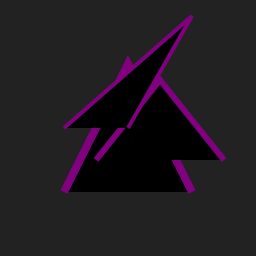

Prediction time for description 'gray wool coat with ...': 23.7146 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><path d="M128 20 L176 100 L256 150 L192 220 L128 250 L64 220 L0 150 L64 100 Z" fill="gray"/><path d="M128 20 L128 50" fill="black"/></svg>


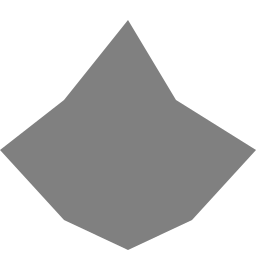

Prediction time for description 'a lighthouse overloo...': 24.1870 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="128" width="256" height="128" fill="blue"/><rect x="128" y="0" width="64" height="128" fill="gray"/><path d="M128 0 L192 64 L128 128 L64 64 Z" fill="white"/></svg>


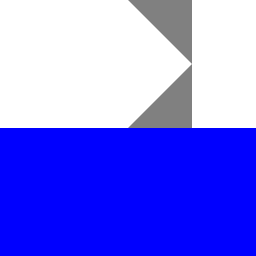

Prediction time for description 'burgundy corduroy pa...': 33.9642 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="64" y="64" width="128" height="160" fill="#800040"/><rect x="80" y="80" width="32" height="40" fill="#a0a0a0"/><rect x="168" y="80" width="32" height="40" fill="#a0a0a0"/><circle cx="96" cy="112" r="8" fill="silver"/><circle cx="176" cy="112" r="8" fill="silver"/></svg>


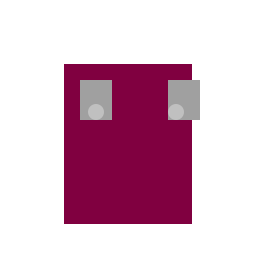

Prediction time for description 'orange corduroy over...': 37.3046 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="64" width="256" height="192" fill="#FFA500" stroke="black" stroke-width="2"/><polyline points="0,64 32,128 64,64" fill="black"/><polyline points="256,64 224,128 192,64" fill="black"/><polyline points="0,192 32,128 64,192" fill="black"/><polyline points="256,192 224,128 192,192" fill="black"/></svg>


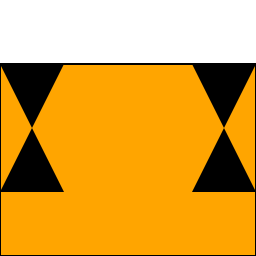

Prediction time for description 'a purple silk scarf ...': 25.7015 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><path d="M16,128 C48,32 128,32 192,128" fill="purple" stroke="none"/><path d="M16,128 C48,224 128,224 192,128" fill="none" stroke="purple" stroke-width="8" transform="translate(0,-64)"/></svg>


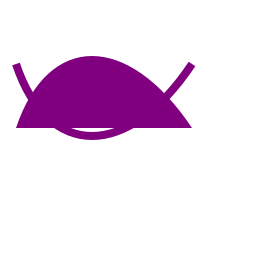

Prediction time for description 'a green lagoon under...': 17.9772 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="128" width="256" height="128" fill="green"/><ellipse cx="128" cy="64" rx="128" ry="32" fill="skyblue"/></svg>


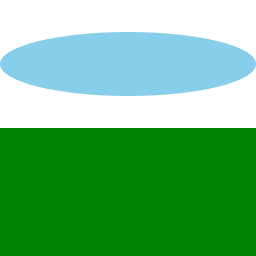

Prediction time for description 'crimson rectangles f...': 55.3273 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="0" width="64" height="64" fill="crimson"/><rect x="64" y="0" width="64" height="64" fill="crimson"/><rect x="128" y="0" width="64" height="64" fill="crimson"/><rect x="0" y="64" width="64" height="64" fill="crimson"/><rect x="64" y="64" width="64" height="64" fill="crimson"/><rect x="128" y="64" width="64" height="64" fill="crimson"/><rect x="0" y="128" width="64" height="64" fill="crimson"/><rect x="64" y="128" width="64" height="64" fill="crimson"/><rect x="128" y="128" width="64" height="64" fill="crimson"/></svg>


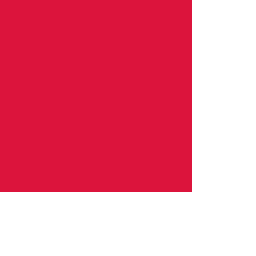

Prediction time for description 'purple pyramids spir...': 101.7932 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><defs><radialGradient id="coneGradient" cx="50%" cy="50%" r="50%" fx="50%" fy="50%"><stop offset="0%" stop-color="brown"/><stop offset="100%" stop-color="orange"/></radialGradient><linearGradient id="pyramidGradient" x1="0%" y1="0%" x2="100%" y2="100%"><stop offset="0%" stop-color="purple"/><stop offset="100%" stop-color="indigo"/></linearGradient></defs><path d="M128 20 L160 80 100 140 128 20 Z" fill="url(#pyramidGradient)" transform="rotate(30, 128, 128)"/><path d="M128 20 L160 80 100 140 128 20 Z" fill="url(#pyramidGradient)" transform="rotate(60, 128, 128)"/><path d="M128 20 L160 80 100 140 128 20 Z" fill="url(#pyramidGradient)" transform="rotate(90, 128, 128)"/><path d="M128 20 L160 80 100 140 128 20 Z" fill="url(#pyramidGradient)" transform="rotate(120, 128, 128)"/><path d="M128 20 L160 80 100 140 128 20 Z" fill="url(#pyramidGradient)" transform="rotate(

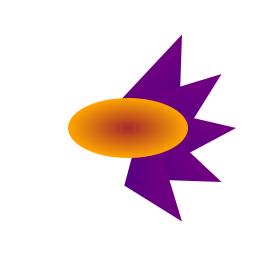

Prediction time for description 'magenta trapezoids l...': 28.3546 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="0" width="256" height="256" fill="silver" opacity="0.3"/><polygon points="20,20 100,128 200,128 240,20" fill="magenta"/><polygon points="20,100 100,188 200,188 240,100" fill="magenta"/></svg>


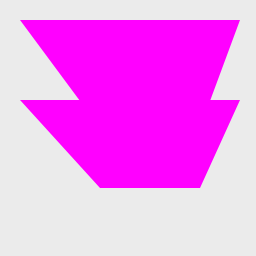

Prediction time for description 'a snowy plain...': 27.2605 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="0" width="256" height="256" fill="#f0f0f0"/><polyline points="0,128 L 256,128" stroke="#ffffff" stroke-width="2"/><circle cx="50" cy="100" r="10" fill="#ffffff"/><circle cx="200" cy="150" r="8" fill="#ffffff"/></svg>


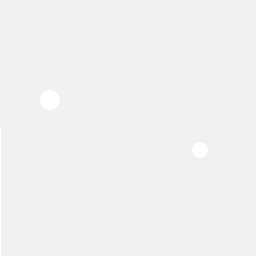

Prediction time for description 'black and white chec...': 67.2563 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="0" width="256" height="256" fill="white"/><g transform="translate(64 64)"><rect x="0" y="0" width="64" height="64" fill="black"/><rect x="32" y="32" width="64" height="64" fill="white"/></g><g transform="translate(128 64)"><rect x="0" y="0" width="64" height="64" fill="white"/><rect x="32" y="32" width="64" height="64" fill="black"/></g><g transform="translate(64 128)"><rect x="0" y="0" width="64" height="64" fill="white"/><rect x="32" y="32" width="64" height="64" fill="black"/></g><g transform="translate(128 128)"><rect x="0" y="0" width="64" height="64" fill="black"/><rect x="32" y="32" width="64" height="64" fill="white"/></g></svg>


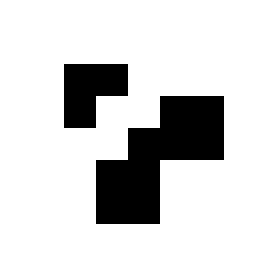

Prediction time for description 'a starlit night over...': 35.5715 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="0" width="256" height="128" fill="#f0f0f0"/><polygon points="128,0 164,64 256,128 192,192 128,160 64,192 0,128 36,64" fill="#333" stroke="#fff" stroke-width="2"/><circle cx="48" cy="80" r="8" fill="#fff"/><circle cx="208" cy="104" r="6" fill="#fff"/></svg>


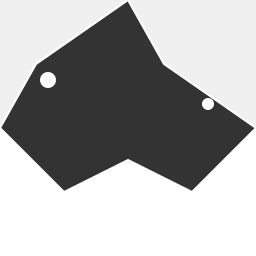

Prediction time for description 'khaki triangles and ...': 19.5140 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><path d="M128 256 L0 128 L256 128 Z" fill="khaki"/><path d="M128 0 L0 128 L256 128 Z" fill="azure"/></svg>


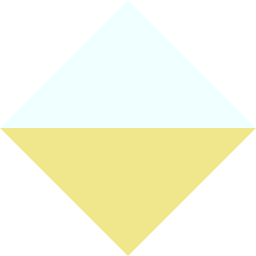

Prediction time for description 'a maroon dodecahedro...': 131.9684 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><polygon points="128 20 165.29 70.93 190.58 121.86 190.58 190.58 165.29 229.07 128 229.07 90.71 229.07 65.42 200 50.71 165.29 41.42 128 61.42 90.71 65.42 75.81 89.42 100 102.81 114.81 128 128 141.42 150.71 154.81 165.29 165.29 190.58 165.29 229.07 128 229.07 90.71" fill="maroon"/><path d="M128 20L165.29 70.93" stroke="teal" stroke-width="3"/><path d="M165.29 70.93L190.58 121.86" stroke="teal" stroke-width="3"/><path d="M190.58 121.86L190.58 190.58" stroke="teal" stroke-width="3"/><path d="M165.29 229.07L128 229.07" stroke="teal" stroke-width="3"/><path d="M90.71 229.07L65.42 200" stroke="teal" stroke-width="3"/><path d="M65.42 200L50.71 165.29" stroke="teal" stroke-width="3"/><path d="M41.42 128L90.71 65.42" stroke="teal" stroke-width="3"/><path d="M128 61.42L141.42 50.71" stroke="teal" stroke-width="3"/><path d="M150.71 41.42L165.29 30.93" stroke="teal" strok

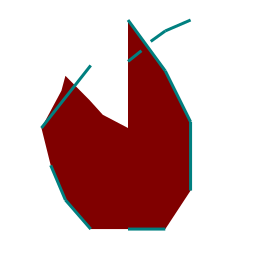

id,description
str,str
"""02d892""","""a purple forest at dusk"""
"""0dcd2e""","""gray wool coat with a faux fur…"
"""1e9ac1""","""a lighthouse overlooking the o…"
"""2b25db""","""burgundy corduroy pants with p…"
"""4e6a54""","""orange corduroy overalls"""
…,…
"""9b71cc""","""a snowy plain"""
"""a395a3""","""black and white checkered pant…"
"""ad4c5c""","""a starlit night over snow-cove…"


In [4]:
import polars as pl
import pandas as pd
train = pl.read_csv('/kaggle/input/drawing-with-llms/train.csv')

def generate():

    from IPython.display import SVG
    import time  # Import the time module
    
    logging.basicConfig(level=logging.ERROR, force=True)
    
    display(train.head())
    
    model = Model()
    svgs = []
    for desc in train.get_column('description'):
        start_time = time.time()  # Record start time
        svg = model.predict(desc)
        end_time = time.time()    # Record end time
        elapsed_time = end_time - start_time # Calculate elapsed time
        
        print(f"Prediction time for description '{desc[:20]}...': {elapsed_time:.4f} seconds") # Print time
        print(svg)
        try:
            display(SVG(svg))
        except Exception as e:
            print(e)
            continue

# Uncomment and run the line below to see some generated images
generate()

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
train